In [1]:
# Librerias
library(ArrayExpress)
library(affy)
library(ggplot2)
library(reshape2)
library(edgeR)
library(Biobase)
library(GEOquery)
library(limma)
library(pander)
library(reshape2)
library(ggplot2)
library(caret)
library(randomForest)
library(caTools)
library(dplyr)
library(ROCR)
library(plotROC)
library(pROC)
library(ggpubr)
library(cvAUC)
library(Boruta)

library(tidyverse)
library(lubridate)
library(scales)
library(Cairo)
library(readODS)

workingDir <- getwd()
if(!dir.exists("data")) dir.create("data")
dataDir <-file.path(workingDir, "data")
if(!dir.exists("results")) dir.create("results")
resultsDir <- file.path(workingDir,"results")
if(!dir.exists("celfiles")) dir.create("celfiles")
celfilesDir <- file.path(workingDir,"celfiles")



Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs

The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min

Welcome to Bioconductor

    Vignettes contain introductory material; view with


**Obtención de los datos RNAseq**

Introducir el códio de los datos RNAseq en la base de datos GEO, con el préfijo GSE.

In [3]:
#geo.accession <- 'GSE89843' #GSE68086 #GSE40419 #GSE107868
geo.accession<-readline(prompt="Enter GEO code GSE...: ")
# ver las carpetas disponibles para bajar 
filePathss = getGEOSuppFiles(geo.accession, makeDirectory = FALSE, baseDir = dataDir, fetch_files=FALSE)
print(filePathss$fname)

# Cargar matriz de expresión
if (length(filePathss$fname)>1){
archivo<-readline(prompt="Enter número donde esta count matrix: ")
archivo<-as.integer(archivo)
print(filePathss$fname[archivo])

filePaths<-paste(dataDir,filePathss$fname[archivo],sep = "/")

} else{
  filePaths<-paste(dataDir,filePathss$fname,sep = "/")
  
}



if (!file.exists(filePaths)){
    getGEOSuppFiles(geo.accession, makeDirectory = FALSE, baseDir = dataDir)
}
gse <- 
  read.table(filePaths, header=TRUE, sep="", na.strings="NA", dec=".", strip.white=TRUE)

# Cargar tabla de anotaciones del RNA seq

# Paths donde su ubica el rchivo
filePaths<-paste(dataDir, geo.accession,sep = "/")

# Nombre del archivo
archivogset<- paste("gset",geo.accession, sep = ".")

# Comprueba si no ha sido descargado con anterioridad
if (! file.exists(filePaths) ){
    dir.create(filePaths, showWarnings = FALSE, recursive = FALSE, mode = "0777")
    Sys.chmod(filePaths, mode = "0777", use_umask=TRUE)
    
    gset <- getGEO(geo.accession, destdir = filePaths, GSEMatrix =TRUE)
    archivogset<- paste("gset",geo.accession, sep = ".")
    save(gset, file = paste(filePaths,archivogset, sep = "/"))
         
} else{
  setwd(filePaths)
  load(archivogset,  verbose = FALSE)
      
    }
# se asigna el cógigo GEO GSM como nombre de genes.
#if (length(gset) > 1) idx <- grep("GPL5188", attr(gset, "names")) else idx <- 1
if (length(gset) > 1) idx <- grep("GPL16791", attr(gset, "names")) else idx <- 1
    gset <- gset[[idx]]

Enter GEO code GSE...: GSE89843
[1] GSE89843_Best_et_al_Cancer_Cell_2017_Table_S1_conversion_to_GEO.xlsx
[2] GSE89843_TEP_Count_Matrix.txt.gz                                    
2 Levels: GSE89843_Best_et_al_Cancer_Cell_2017_Table_S1_conversion_to_GEO.xlsx ...
Enter número donde esta count matrix: 2
[1] GSE89843_TEP_Count_Matrix.txt.gz
2 Levels: GSE89843_Best_et_al_Cancer_Cell_2017_Table_S1_conversion_to_GEO.xlsx ...


**Exploración de los datos**

**Título**

In [4]:
pander(gset@experimentData@title)

Swarm intelligence-enhanced detection of non-small cell lung cancer using tumor-educated platelets

**Autores**

In [5]:
gset@experimentData@name

[1] "Myron,,Best"

**Resumen**

In [6]:
pander(gset@experimentData@abstract)

We report RNA-sequencing data of 779 blood platelet samples, including 402 tumor-educated platelet (TEP) samples collected from patients with non-small cell lung cancer (NSCLC). In addition, we report RNA-sequencing data of blood platelets isolated from 377 individuals without reported cancer, but not excluding individuals with inflammatory conditions. This dataset highlights the ability of TEP RNA-based 'liquid biopsy' diagnostics in patients with NSCLC.

**Web de descarga**

In [7]:
gset@experimentData@url

[1] "https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE89843"

**Diseño experimental**

In [8]:
design.experimental<-gset@phenoData@data[["extract_protocol_ch1"]]
d.exp<-design.experimental[1]

print(as.character(design.experimental[1]))

[1] "Blood platelets were isolated from whole blood in purple-cap BD Vacutainers containing the EDTA anti-coagulant. The cells and aggregates were removed by centrifugation at room temperature for 20 minutes at 120g, resulting in platelet-rich plasma. The platelets were isolated from the platelet-rich plasma by centrifugation at room temperature for 20 minutes at 360g. The platelet pellet was collected in 30 Î¼l RNAlater (Life Technologies), incubated overnight at 4Â°C and frozen at -80Â°C for further use. Frozen platelets were thawed on ice and total RNA was isolated using the mirVana RNA isolation kit (Life Technologies) according to the manufacturersâ\200\231 protocol. Complementary purification of small RNAs was included in the isolation procedure by addition of miRNA homogenate (Life Technologies). Total RNA was dissolved in 30 Î¼l Elution Buffer (Life Technologies) and RNA quality and quantity was measured using Bioanalyzer 2100 with RNA 6000 Picochip (Agilent)."


In [9]:
gset@phenoData@data[["platform_id"]][[1]]
#print(plataforma)

[1] GPL16791
Levels: GPL16791

**Target**

In [10]:
str(gset@phenoData@data)

'data.frame':	779 obs. of  40 variables:
 $ title                  : Factor w/ 779 levels "Blood_Platelets_AMC-HD-001-TR1139",..: 257 258 259 260 261 262 263 264 265 266 ...
 $ geo_accession          : chr  "GSM2390709" "GSM2390710" "GSM2390711" "GSM2390712" ...
 $ status                 : Factor w/ 1 level "Public on Aug 15 2017": 1 1 1 1 1 1 1 1 1 1 ...
 $ submission_date        : Factor w/ 3 levels "May 15 2017",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ last_update_date       : Factor w/ 1 level "May 15 2019": 1 1 1 1 1 1 1 1 1 1 ...
 $ type                   : Factor w/ 1 level "SRA": 1 1 1 1 1 1 1 1 1 1 ...
 $ channel_count          : Factor w/ 1 level "1": 1 1 1 1 1 1 1 1 1 1 ...
 $ source_name_ch1        : Factor w/ 1 level "Thrombocytes": 1 1 1 1 1 1 1 1 1 1 ...
 $ organism_ch1           : Factor w/ 1 level "Homo sapiens": 1 1 1 1 1 1 1 1 1 1 ...
 $ characteristics_ch1    : Factor w/ 10 levels "disease: Chronic Pancreatitis",..: 3 3 3 3 3 3 3 3 3 3 ...
 $ molecule_ch1           : Factor w

In [11]:
g.interes<-readline(prompt="Enter grupos de interés: ")
variable.interes<-factor(gset@phenoData@data[[g.interes]])

#variable.interes<-factor(gset@phenoData@data[["disease:ch1"]])
summary(variable.interes)


Enter grupos de interés: disease:ch1


Chronic Pancreatitis                        Epilepsy 
                              5                              21 
                Healthy Control              Multiple Sclerosis 
                            231                              58 
Non-significant Atherosclerosis                       nonCancer 
                             12                               6 
                          NSCLC          Pulmonary Hypertension 
                            402                              34 
         Stable Angina Pectoris        Unstable Angina Pectoris 
                              4                               6

In [12]:
# Lo paso a caracteres
grupo_cancer<-as.character(variable.interes)
# Itinerador
recuento=0

v.interes<-readline(prompt="Enter variable de interés: ")
#v.interes<-"NSCLC"

for (i in variable.interes) {recuento = recuento+1
  if (i == v.interes){
    grupo_cancer[recuento]= v.interes
    
  } else {
grupo_cancer[recuento]="Control"
    
}
    
}
grupo_cancer<-factor(grupo_cancer)
summary(grupo_cancer)

Enter variable de interés: NSCLC


Control   NSCLC 
    377     402

Ajustes del formato de los datos

In [13]:
Tipo<-gset@phenoData@data[["type"]]
Namecode<-gset@phenoData@data[["geo_accession"]]
grupos<-variable.interes
Grupo_dicotomico<-grupo_cancer


target<-data.frame(Namecode,grupos,Grupo_dicotomico)
# objeto tabla
write.table(target, file=file.path(dataDir, "targets.txt"), 
             sep="\t", row.names=FALSE, quote=FALSE)

if (length(gse) > length(grupo_cancer)){
    row.names(gse)<-gse[,1]
    gse=gse[,-1]
    
  }

dge=DGEList(gse,group=grupo_cancer,remove.zeros=TRUE)


keep <- filterByExpr(dge)
filtrado <- dge[keep, , keep.lib.sizes=FALSE]






**Distribuciones de las muestras**


[1] 4656  779

[1] 4722  779

Warning message in melt(logcpm, na.rm = FALSE, as.is = FALSE, value.name = "expresion"):
"The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(logcpm). In the next version, this warning will become an error."

'data.frame':	3627024 obs. of  3 variables:
 $ Var2     : Factor w/ 10 levels "Contr.Healthy Control",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ expresion: num  1.9 4.02 3.5 3.6 3.23 ...
 $ cell_line: Factor w/ 2 levels "Contr","NSCLC": 1 1 1 1 1 1 1 1 1 1 ...
function (x, df1, df2, ncp, log = FALSE)  


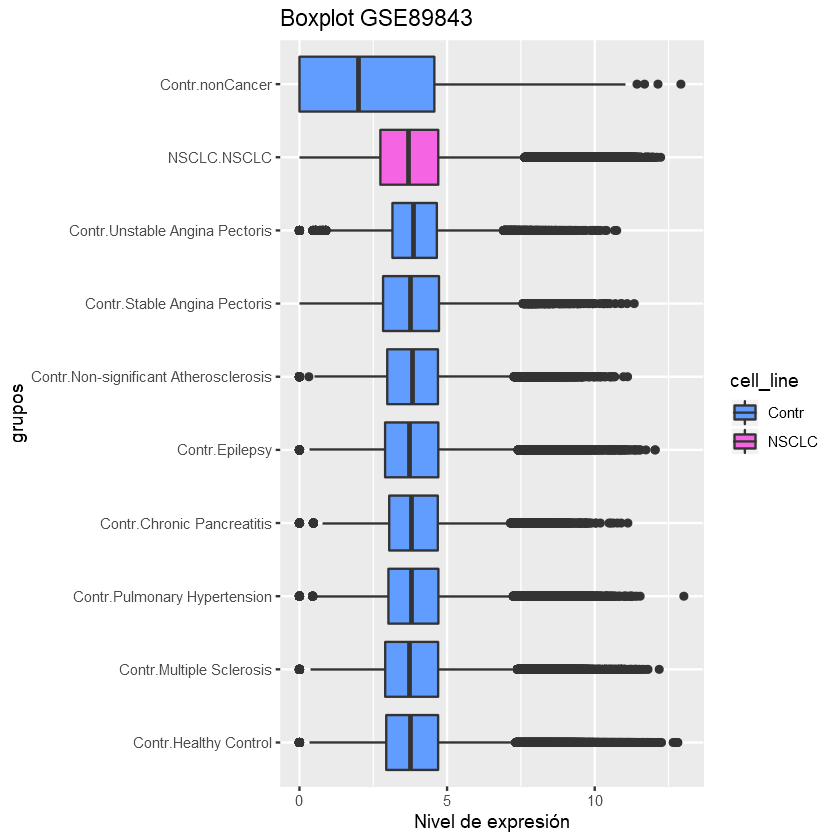

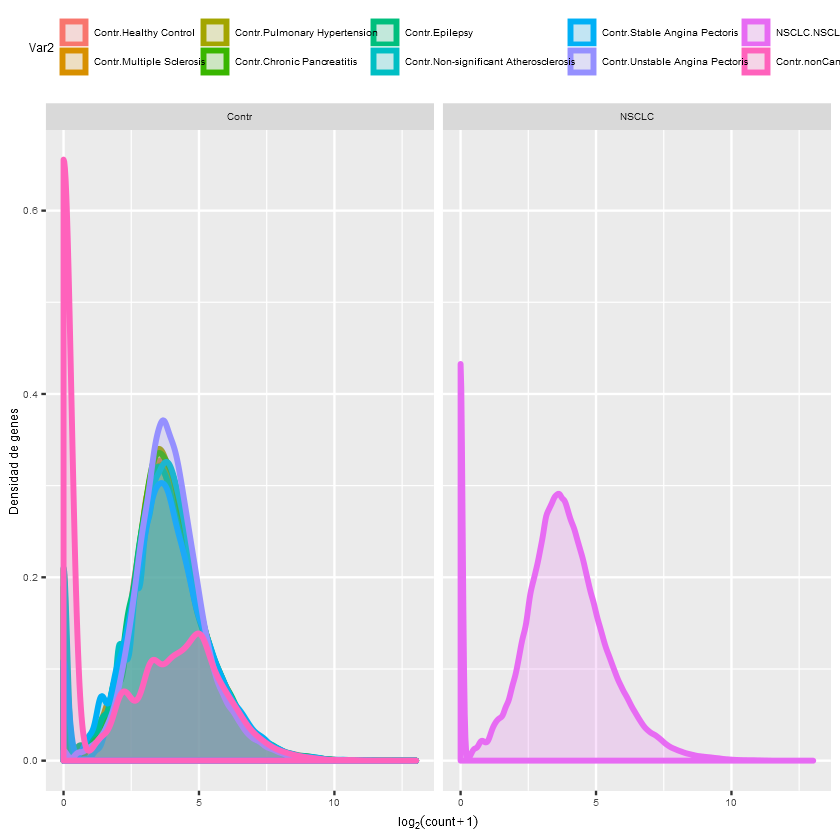

In [15]:


#filtrado2 <- calcNormFactors(dge)

#n_cpm<-readline(prompt="Enter  Recuento mínimo requerido para al menos algunas muestras : ")

#n_bibliotecas<-readline(prompt=" Recuento total mínimo requerido : ")

###
#n_cpm<-as.integer(n_cpm)
#n_bibliotecas<-as.integer(n_bibliotecas)
# keep <- filterByExpr(dge,min.count = n_cpm, min.total.count = n_bibliotecas,group=Grupo_dicotomico)
keep <- filterByExpr(dge,group=Grupo_dicotomico)
#keep <- filterByExpr(filtrado2,min.count = n_cpm, min.total.count = n_bibliotecas,group=Grupo_dicotomico)
#keep <- filterByExpr(dge) #,group=variable.interes
#filtrado <- dge[keep,]
####


#keep <- rowSums(cpm(dge)>n_cpm) >= n_bibliotecas
filtrado <- dge[keep, , keep.lib.sizes=FALSE]
#head(filtrado$samples)
dim(filtrado)
dim(dge)


filtrado <- calcNormFactors(filtrado)
d_nor_filt<-filtrado
siglas_pacientes<-variable.interes
grupos_cancer<-grupo_cancer
logcpm<-log(cpm(filtrado)+1)

siglas_pacientes<-factor(siglas_pacientes)

union <- factor(paste(substr(grupos_cancer,1,5),siglas_pacientes,sep="."))
colnames(logcpm)<-union


meltcpm <- melt(logcpm, na.rm = FALSE, as.is = FALSE, value.name = "expresion")

meltcpm = data.frame(meltcpm[,2:3], cell_line =substr(meltcpm$Var2, 1,5))
str(meltcpm)
str(df)

ggplot(meltcpm, aes(x = Var2, y = expresion, fill = cell_line)) + geom_boxplot() + xlab("") + ylab(expression(log[2](count + 1))) +
  ggtitle ("Boxplot GSE89843") +
  labs(x = "grupos",y = "Nivel de expresión")+
coord_flip() + scale_fill_manual(values = c("#619CFF", "#F564E3"))

ggplot(meltcpm, aes(x = expresion, colour = Var2, fill = Var2))  +
  theme (text = element_text(size=7))+
  geom_density(alpha = 0.2, size = 1.25) + facet_wrap(~ cell_line) +
  labs(x = "Nivel de expresión",y = "Densidad de genes")+
  theme(legend.position = "top") + xlab(expression(log[2](count + 1)))


**Identificación de genes diferencialmente expresados**

Contraste de hipótesis
- H0= los genes se expresan al mismo nivel en los diferentes grupos.
- H1= los genes se expresan diferente en los grupos.

Design matrix not provided. Switch to the classic mode.


       NSCLC-Control
Down             446
NotSig          3715
Up               495

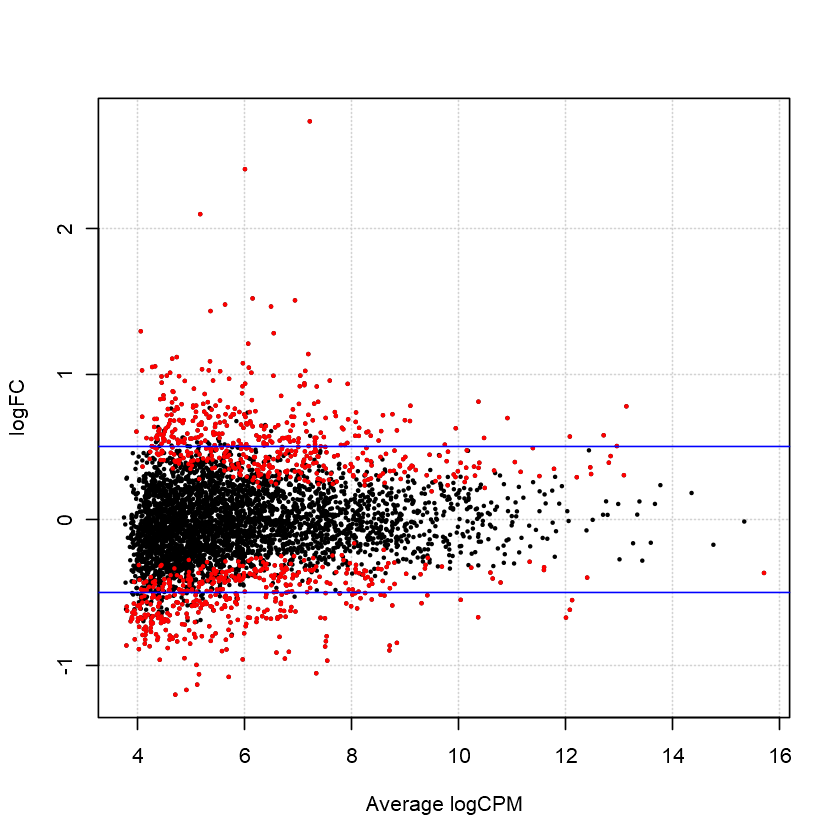

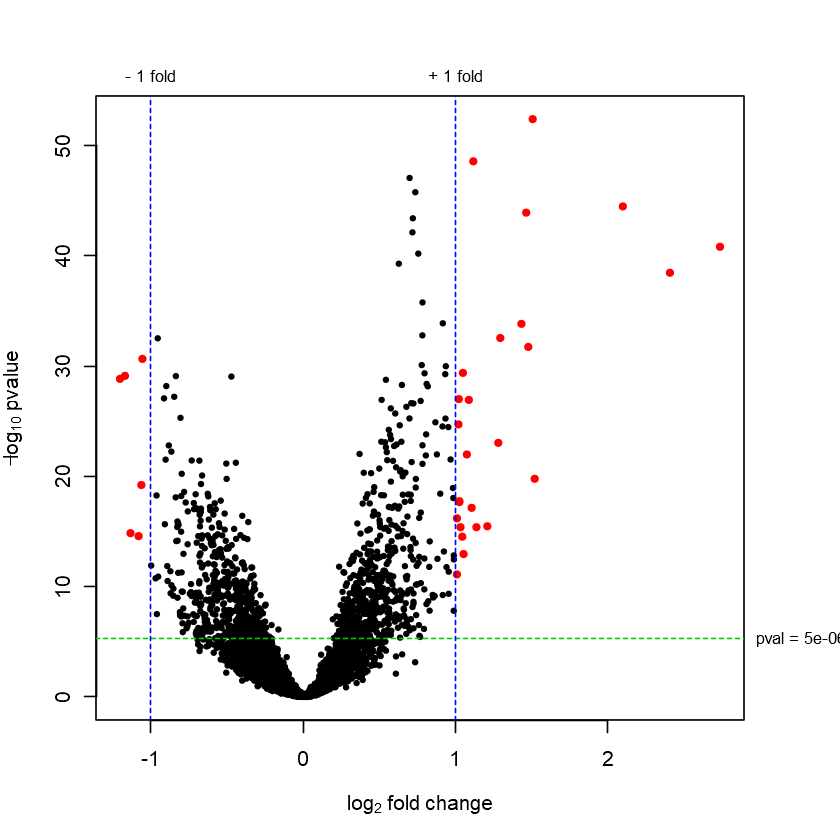

In [16]:
dge1 <- estimateDisp(d_nor_filt)
et <- exactTest(dge1)

cutoff=p=0.000005

de = decideTestsDGE(et, p = cutoff, adjust = "BH")
summary(de)

detags = rownames(et)[as.logical(de)]
plotSmear(et, de.tags = detags)
abline(h = c(-0.5, 0.5), col = "blue")


tab = data.frame(logFC = et$table[, 1], negLogPval = -log10(et$table[, 3]))
row.names(tab)<-row.names(et$table)
par(mar = c(5, 4, 4, 4))
plot(tab, pch = 16, cex = 0.6, xlab = expression(log[2]~fold~change),
ylab = expression(-log[10]~pvalue))
## Log2 fold change and p-value cutoffs
lfc = 1
pval = cutoff
## Selecting interest genes
signGenes = (abs(tab$logFC) > lfc & tab$negLogPval > -log10(pval))
## Identifying the selected genes
points(tab[signGenes, ], pch = 16, cex = 0.8, col = "red")
abline(h = -log10(pval), col = "green3", lty = 2)
abline(v = c(-lfc, lfc), col = "blue", lty = 2)
mtext(paste("pval =", pval), side = 4, at = -log10(pval), cex = 0.8, line = 0.5, las = 1)
mtext(c(paste("-", lfc, "fold"), paste("+", lfc, "fold")), side = 3, at = c(-lfc, lfc),
cex = 0.8, line = 0.5)


Preparamos una validación cruzada, consiste en subdividir los datos en grupos (folds) con los que entrenar el modelo para predecir el resto de datos, los resultados de cada entrenamiento son independientes, por lo que se muestra la precisión en un diagrama de cajas, cuanto mas amplio sea mas interviene el azar en la partición de los datos. 

In [17]:

set.seed(234567)

k<-readline(prompt="Número de folds : ")
k<-as.integer(k)
folds <- createFolds(grupo_cancer, k = k)


Número de folds : 5


Pondremos una lista con el número de genes que queremos para una firma genética.

In [44]:
tops<-list()
genestop<-list()
k <- "enter lista de número de genes para firmas geneticas separado por comas, como maximo 9 grupos \n"
#k<-readline(prompt="enter the experiment numbers (space-separated list) \n ")
n_genes <- as.integer(strsplit(readline(k), ",")[[1]])

#n_genes<-c(5,10,15,20,30,40,50,100,150)

enter lista de número de genes para firmas geneticas separado por comas, como maximo 9 grupos 
20,30,40,50,60,70,100,200,300


Rendimiento del clasificador en 

los diferentes grupos, el grupo que se ha elegído para contrastar con el resto será la especificidad es decir la precisión con la que se predice la condición cuando existe y el resto la sensibilidad es decir la precisión con la que no se predice la condición si no existe. 

[1] " 20 genes"
          Reference
Prediction Control NSCLC
   Control     304    73
   NSCLC        77   325
[1] " 30 genes"
          Reference
Prediction Control NSCLC
   Control     317    60
   NSCLC        77   325
[1] " 40 genes"
          Reference
Prediction Control NSCLC
   Control     321    56
   NSCLC        70   332
[1] " 50 genes"
          Reference
Prediction Control NSCLC
   Control     317    60
   NSCLC        66   336
[1] " 60 genes"
          Reference
Prediction Control NSCLC
   Control     316    61
   NSCLC        71   331
[1] " 70 genes"
          Reference
Prediction Control NSCLC
   Control     320    57
   NSCLC        67   335
[1] " 100 genes"
          Reference
Prediction Control NSCLC
   Control     316    61
   NSCLC        68   334
[1] " 200 genes"
          Reference
Prediction Control NSCLC
   Control     319    58
   NSCLC        63   339
[1] " 300 genes"
          Reference
Prediction Control NSCLC
   Control     319    58
   NSCLC        64   33

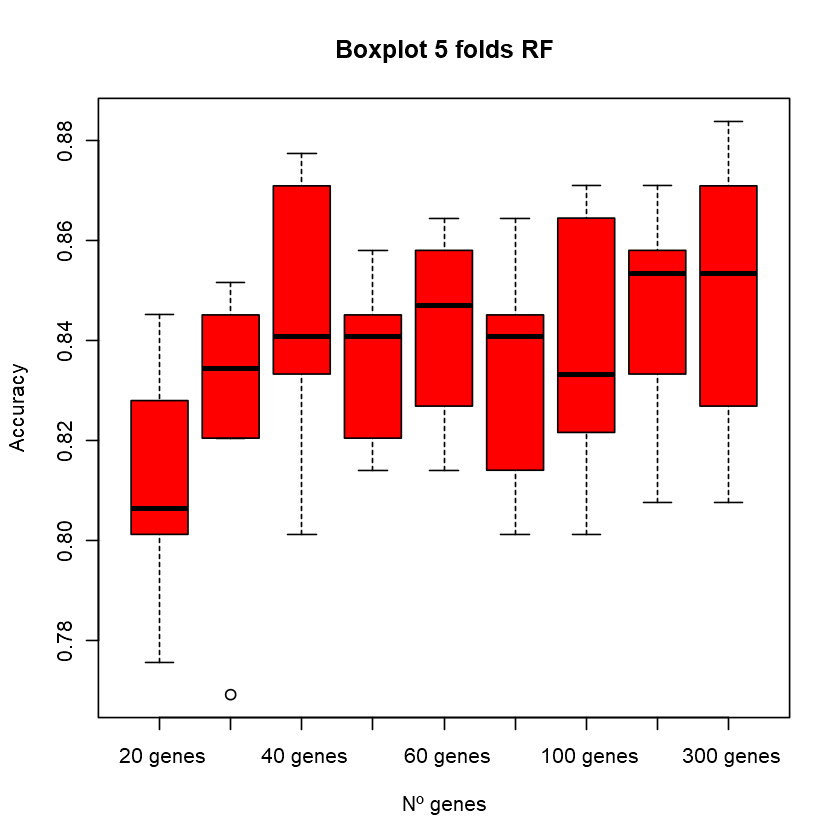

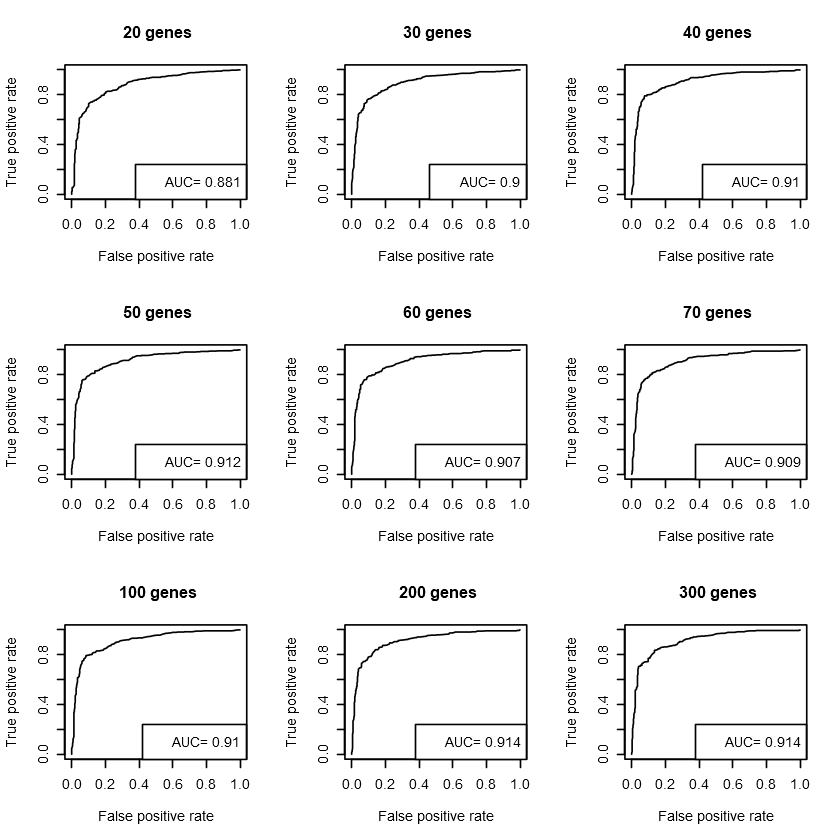

In [45]:



for (i in 1:length(n_genes)) {
tops[[i]] <-topTags(et,n=n_genes[i])

}


for (i in 1:length(tops)) {
 genestop[[i]]<-row.names(tops[[i]]$table)
    
}

include_genestop<-list()
for (i in 1:length(tops)) {
 include_genestop[[i]]<-subset(gse, rownames(gse) %in% genestop[[i]])
}

newdata_include_genestop<-list()
tinclude_genestop<-list()
tinclude_genesdatostop<-list()


for (i in 1:length(tops)) {
 
 tinclude_genestop[[i]]<-t(include_genestop[[i]])
 
 tinclude_genesdatostop[[i]]<-data.frame(tinclude_genestop[[i]],grupo_cancer,variable.interes)
 
newdata_include_genestop[[i]] <-data.frame(tinclude_genestop[[i]],grupo_cancer)
  

}


set.seed(234567)

contador1<-0

t_pred<-list()



for (i in newdata_include_genestop[1:length(newdata_include_genestop)]) {
  contador1<-contador1+1

  j<-tinclude_genesdatostop[[contador1]]
  
  
  
  tabla_predicion <- lapply(folds, function(x){

  training_fold <- i[-x, ]
  

  test_fold <- i[x, ]
  
  subgruposcondicion<-j[x, ]$variable.interes
  
  
  clasificador <- randomForest(grupo_cancer ~ ., data = training_fold, ntree = 250)
  
  y_pred <- predict(clasificador, newdata = test_fold,type="prob")
  
  pred <- predict(clasificador, newdata = test_fold)
  
  e<-data.frame(test_fold$grupo_cancer,y_pred[,2],pred,subgruposcondicion)
  
  return(e)

  })
  t_pred[[contador1]] <- do.call(rbind.data.frame, tabla_predicion)
  
  }


ee<-lapply(t_pred, function(x){
 
  
  matriz_confusion<-(confusionMatrix(x[,1], x[,3]))
  return(matriz_confusion)

})


for (i in 1:length(n_genes)) {
 #plot(ee[[i]], main=sprintf(" %s %s",n_genes[i],"genes"), colorize=F)
  
  print(sprintf(" %s %s",n_genes[i],"genes"))
  print(ee[[i]]$table)
  
}


set.seed(234567)
Predicciones <- matrix(NA, length(folds), length(tops))

contador1<-0
contador2<-0
impgenes<-list()
for (i in folds[1:length(folds)]) {
  contador1<-contador1+1
  contador2<-0
  mc<-matrix(0, 2, 2)
  
  tabla_pred<-list()
  
  for (j in 1:length(tops)) {
    contador2<-contador2+1
    training_fold <- newdata_include_genestop[[j]][-i, ]
  
    test_fold <- newdata_include_genestop[[j]][i, ]

    clasificador <- randomForest(grupo_cancer ~ ., data = training_fold,importance = TRUE, ntree = 250)
    
    y_pred <- predict(clasificador, newdata = test_fold)
    
    cm <- table(test_fold$grupo_cancer, y_pred)
    
    prec<-(cm[1,1] + cm[2,2]) / (cm[1,1] + cm[2,2] +cm[1,2] + cm[2,1])
    
    
    Predicciones[contador1, contador2]<-prec
    
  }
  
}

colnames(Predicciones)<-sprintf(" %s %s",n_genes,"genes")
row.names(Predicciones)<-names(folds)
boxplot(Predicciones, main = "Boxplot 5 folds RF", xlab = "Nº genes", ylab = "Accuracy",col="red")

ee<-lapply(t_pred, function(x){
 
  forestpred = prediction(x[,2], x[,1])
  forestperf = performance(forestpred, "auc")
  return(forestperf)

})

for (i in 1:length(n_genes)) {
 
  aucs <- (ee[[i]]@y.values)
  # print(sprintf("AUC %s %s %s",n_genes[i],"genes",aucs))
  
}

eee<-lapply(t_pred, function(x){
 
  forestpred = prediction(x[,2], x[,1])
  forestperf = performance(forestpred, "tpr", "fpr")
  return(forestperf)

})

par(mfrow=c(3,3))
for (i in 1:length(n_genes)) {
 plot(eee[[i]], main=sprintf(" %s %s",n_genes[i],"genes"), colorize=F)
  
  aucs<-round(as.numeric(ee[[i]]@y.values),3)
  legend(x = "bottomright", legend = sprintf(" %s %s","AUC=",aucs))
}


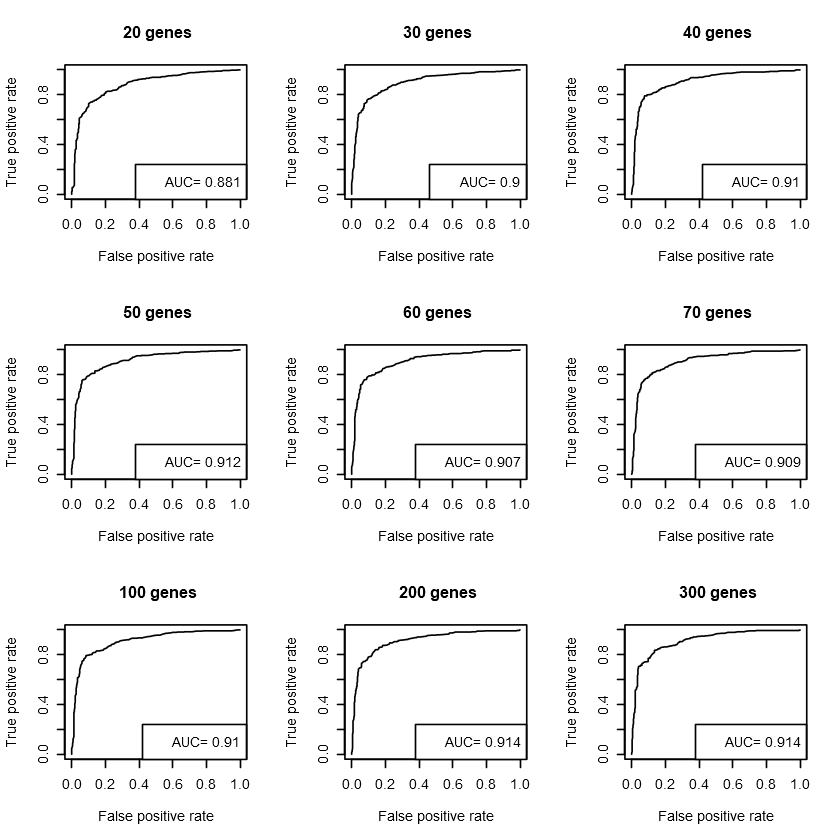

In [46]:
ee<-lapply(t_pred, function(x){
 
  forestpred = prediction(x[,2], x[,1])
  forestperf = performance(forestpred, "auc")
  return(forestperf)

})

for (i in 1:length(n_genes)) {
 
  aucs <- (ee[[i]]@y.values)
  # print(sprintf("AUC %s %s %s",n_genes[i],"genes",aucs))
  
}

eee<-lapply(t_pred, function(x){
 
  forestpred = prediction(x[,2], x[,1])
  forestperf = performance(forestpred, "tpr", "fpr")
  return(forestperf)

})

par(mfrow=c(3,3))
for (i in 1:length(n_genes)) {
 plot(eee[[i]], main=sprintf(" %s %s",n_genes[i],"genes"), colorize=F)
  
  aucs<-round(as.numeric(ee[[i]]@y.values),3)
  legend(x = "bottomright", legend = sprintf(" %s %s","AUC=",aucs))
}

La función boruta busca los genes importantes en la clasificación



|    &nbsp;    | 20 genes | 30 genes | 40 genes | 50 genes | 60 genes |
|:------------:|:--------:|:--------:|:--------:|:--------:|:--------:|
| **Accuracy** |  0.8498  |  0.8537  |  0.8549  |  0.8549  |  0.8485  |

Table: Table continues below

 

|    &nbsp;    | 70 genes | 100 genes | 200 genes | 300 genes |
|:------------:|:--------:|:---------:|:---------:|:---------:|
| **Accuracy** |  0.8524  |  0.8498   |  0.8472   |  0.8408   |



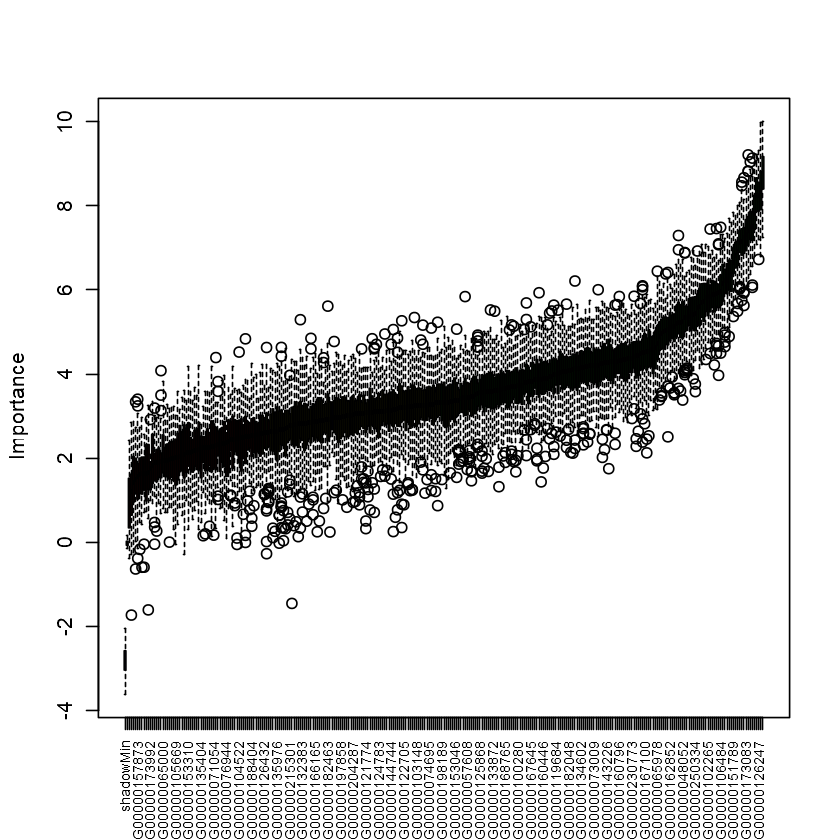

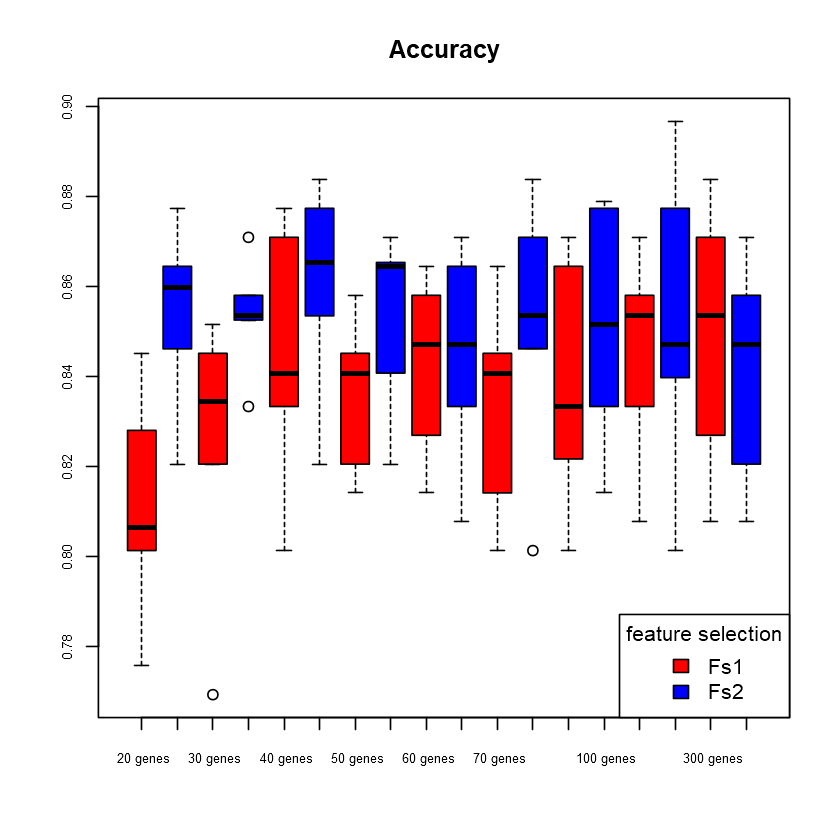

In [47]:

boruta.train <- Boruta(grupo_cancer~., data = newdata_include_genestop[[length(n_genes)]] )

plot(boruta.train, xlab = "", xaxt = "n")
lz<-lapply(1:ncol(boruta.train$ImpHistory),function(i)
boruta.train$ImpHistory[is.finite(boruta.train$ImpHistory[,i]),i])
names(lz) <- colnames(boruta.train$ImpHistory)
Labels <- sort(sapply(lz,median))
axis(side = 1,las=2,labels = names(Labels),
at = 1:ncol(boruta.train$ImpHistory), cex.axis = 0.7)



boruta_imp<-rev(sort(Labels)) 
boruta_imp<-names(boruta_imp)
x<-boruta_imp

rankImportance<-list()

for (i in 1:length(n_genes)) {
 
 rankImportance [[i]]<-boruta_imp[1:n_genes[i]] 
}

sc3<-rankImportance

selec_genes<-list()
for (i in 1:length(sc3)) {
x<-sc3


selec_genes[[i]] <-subset(gse, rownames(gse) %in% x[[i]])
}
sg3<-selec_genes

tinclude_genes3<-sg3
tinclude_genesdatos3<-sg3
newdata_include_genes3<-sg3

for (i in 1:length(tinclude_genes3)) {
  
    tinclude_genes3[[i]]<-data.frame(t(tinclude_genes3[[i]]))
    tinclude_genesdatos3[[i]]<-data.frame(tinclude_genes3[[i]],grupo_cancer,variable.interes)
    newdata_include_genes3[[i]] <- data.frame(tinclude_genes3[[i]],grupo_cancer)
  }

set.seed(234567)

contador1<-0

t_pred3<-newdata_include_genes3




for (i in 1:length(newdata_include_genes3)) {
  
  contador1<-contador1+1
 
    
  
    
     z<-newdata_include_genes3[[contador1]]
     y<-tinclude_genesdatos3[[contador1]]
     #print(z)
     
     
     
     
     tabla_predicion <- lapply(folds, function(x){
       
       
       training_fold <- z[-x, ]
       test_fold <- z[x, ]
       subgruposcondicion<-y[x, ]$variable.interes
       

       
       clasificador <- randomForest(grupo_cancer ~ ., data = training_fold, ntree = 250, importancia=TRUE)
       y_pred <- predict(clasificador, newdata = test_fold,type="prob")
       pred <- predict(clasificador, newdata = test_fold)
       e<-data.frame(test_fold$grupo_cancer,y_pred[,2],pred,subgruposcondicion)
       
      
       
      
       prec<-(cm[1,1] + cm[2,2]) / (cm[1,1] + cm[2,2] +cm[1,2] + cm[2,1])
       
       
       
       return(e)

     })
     
     t_pred3[[contador1]] <- do.call(rbind.data.frame, tabla_predicion)

    
  }

aciertos<-list()
ee<-lapply(t_pred3, function(x){
 
  
  matriz_confusion<-(confusionMatrix(x[,1], x[,3]))
  mconfusion<-(matriz_confusion$overall['Accuracy'])
  return(mconfusion)

})
aciertos<-ee


accuracys<-as.data.frame(aciertos)
colnames(accuracys)<-sprintf(" %s %s",n_genes,"genes")
pander(accuracys)

set.seed(234567)
Predicciones3 <- matrix(NA, length(folds), length(tops))

contador1<-0
contador2<-0
#impgenes<-list()
for (i in folds[1:length(folds)]) {
  contador1<-contador1+1
  contador2<-0
  mc<-matrix(0, 2, 2)
  
  tabla_pred<-list()
  
  for (j in 1:length(tops)) {
    contador2<-contador2+1
    training_fold <- newdata_include_genes3[[j]][-i, ]
  
    test_fold <- newdata_include_genes3[[j]][i, ]

    clasificador <- randomForest(grupo_cancer ~ ., data = training_fold,importance = TRUE, ntree = 250)
    
    y_pred <- predict(clasificador, newdata = test_fold)
    
    cm <- table(test_fold$grupo_cancer, y_pred)
    
    prec<-(cm[1,1] + cm[2,2]) / (cm[1,1] + cm[2,2] +cm[1,2] + cm[2,1])
    
    
    Predicciones3[contador1, contador2]<-prec
    
  }
  
}

colnames(Predicciones3)<-sprintf(" %s %s",n_genes,"genes")
row.names(Predicciones3)<-names(folds)

color<-c("red","blue")
colores<-rep(color,length(n_genes))
#print(colores)

contador<-0
n_genes2<-rep(n_genes,2)
comparativa<-matrix(NA, length(folds), length(tops)*2)
for (i in seq (1,length(tops)*2,2) ) {
  contador<-contador+1
  comparativa[,i]<-Predicciones[,contador]
  #comparativa[,i+1]<-Predicciones2[,contador]
  comparativa[,i+1]<-Predicciones3[,contador]
  
  n_genes2[i]<-n_genes[contador]
  #n_genes2[i+1]<-n_genes[contador]
  n_genes2[i+1]<-n_genes[contador]
  
  
}

colnames(comparativa)<-sprintf(" %s %s",n_genes2,"genes")
boxplot(comparativa,col=colores, cex.axis=0.6,main = "Accuracy")
legend(x = "bottomright", legend = c("Fs1", "Fs2"), fill = c("red", "blue"), 
       title = "feature selection")




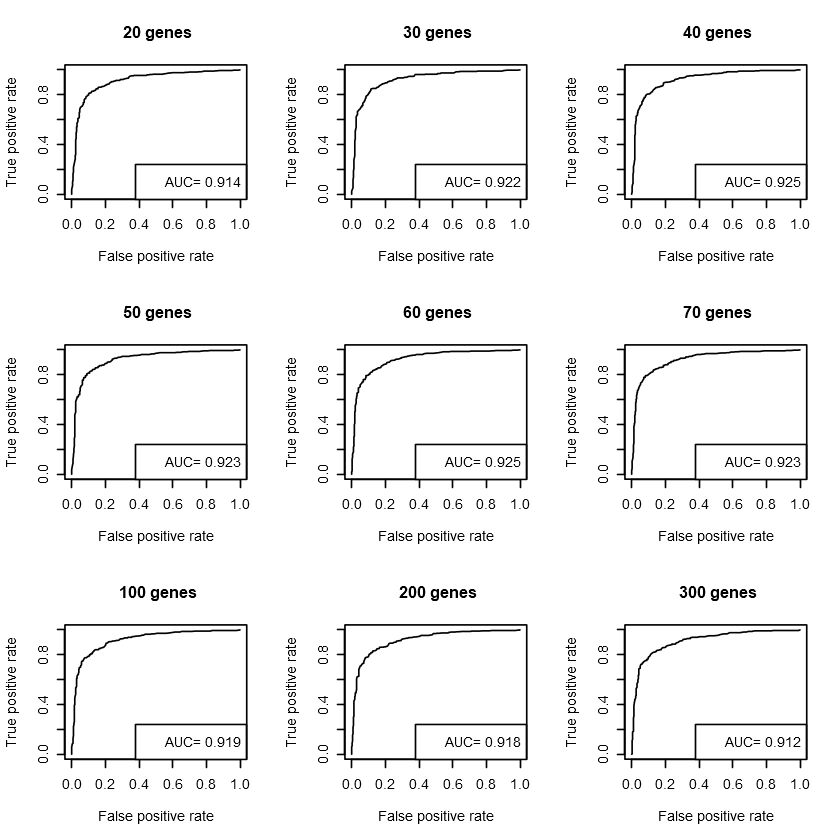

In [48]:
aucss<-lapply(t_pred3, function(x){
 
  forestpred = prediction(x[,2], x[,1])
  forestperf = performance(forestpred, "auc")
  return(forestperf)

})

  ee<-lapply(t_pred3, function(x){
 
  
  forestpred = prediction(x[,2], x[,1])
   forestperf = performance(forestpred, "tpr", "fpr")
  return(forestperf)

})

par(mfrow=c(3,3))
for (i in 1:length(n_genes)) {
  aucs <- (aucss[[i]]@y.values)
  aucs<-as.numeric(aucs)
  aucs<-round(aucs,3) 
   plot(ee[[i]], main=sprintf(" %s %s",n_genes[i],"genes"), colorize=F) 
  legend(x = "bottomright", legend = sprintf(" %s %s","AUC=",aucs))
  }


In [57]:
ee<-lapply(t_pred3, function(x){
 
  forestpred = prediction(x[,2], x[,1])
  forestperf = performance(forestpred, "auc")
  return(forestperf)

})

resumen_grupos<-summary(variable.interes)
sumaroria_resum_g<-length(resumen_grupos)
g<-names(resumen_grupos)
#gg<-do.call(rbind.data.frame, grupo)

#fs_elegido<-t_pred3[[6]]
fs_elegido<-readline(prompt="Enter la posición del clasificador elegido...: ") 
fs<-as.integer(fs_elegido)
print(fs_elegido)
fs_elegido<-as.integer(fs_elegido)
print(n_genes[fs_elegido])
fs_elegido<-t_pred3[[fs_elegido]]

for (i in 1:length(g)) {

gresult <- subset(fs_elegido, fs_elegido$subgruposcondicion %in% g[i])

mc<- table(gresult$test_fold.grupo_cancer, gresult$pred)
print(g[i])

pander(mc)

prec <- (mc[1,1] + mc[2,2]) / (mc[1,1] + mc[2,2] +mc[1,2] + mc[2,1])


print(sprintf("porcentaje de acierto en el grupo  %s %s %s %s",g[i],"es:",prec*100,"%"))


 # forestpred = prediction(gresult[,2], gresult[,1])
#  forestperf = performance(forestpred, "tpr", "fpr")
  
#  print(plot(forestperf, main="curva ROC", colorize=F))

}

Enter la posición del clasificador elegido...: 3
[1] "3"
[1] 40
[1] "Chronic Pancreatitis"


|   &nbsp;    | Control | NSCLC |
|:-----------:|:-------:|:-----:|
| **Control** |    3    |   2   |
|  **NSCLC**  |    0    |   0   |

[1] "porcentaje de acierto en el grupo  Chronic Pancreatitis es: 60 %"
[1] "Epilepsy"


|   &nbsp;    | Control | NSCLC |
|:-----------:|:-------:|:-----:|
| **Control** |   16    |   5   |
|  **NSCLC**  |    0    |   0   |

[1] "porcentaje de acierto en el grupo  Epilepsy es: 76.1904761904762 %"
[1] "Healthy Control"


|   &nbsp;    | Control | NSCLC |
|:-----------:|:-------:|:-----:|
| **Control** |   206   |  25   |
|  **NSCLC**  |    0    |   0   |

[1] "porcentaje de acierto en el grupo  Healthy Control es: 89.1774891774892 %"
[1] "Multiple Sclerosis"


|   &nbsp;    | Control | NSCLC |
|:-----------:|:-------:|:-----:|
| **Control** |   51    |   7   |
|  **NSCLC**  |    0    |   0   |

[1] "porcentaje de acierto en el grupo  Multiple Sclerosis es: 87.9

In [58]:
genes<-names(newdata_include_genes3[[fs]])
library(org.Hs.eg.db)
#keytypes(org.Hs.eg.db)
my.keys <- genes
#my.keys %in% keys(org.Hs.eg.db, keytype="ENSEMBL")

#columns(org.Hs.eg.db)

ann <- select(org.Hs.eg.db, keytype="ENSEMBL", keys=genes,columns=c("SYMBOL","GENENAME"))

ann<-data.frame(ann)
pander(ann)

'select()' returned 1:1 mapping between keys and columns




|     ENSEMBL     |  SYMBOL   |
|:---------------:|:---------:|
| ENSG00000048052 |   HDAC9   |
| ENSG00000097021 |   ACOT7   |
| ENSG00000101335 |   MYL9    |
| ENSG00000102265 |   TIMP1   |
| ENSG00000103202 |   NME4    |
| ENSG00000103512 |   NOMO1   |
| ENSG00000106484 |   MEST    |
| ENSG00000108679 | LGALS3BP  |
| ENSG00000111196 |  MAGOHB   |
| ENSG00000112245 |  PTP4A1   |
| ENSG00000115457 |  IGFBP2   |
| ENSG00000126247 |  CAPNS1   |
| ENSG00000130948 |  HSD17B3  |
| ENSG00000134294 |  SLC38A2  |
| ENSG00000136938 |  ANP32B   |
| ENSG00000138041 |    NA     |
| ENSG00000142089 |  IFITM3   |
| ENSG00000142856 |  ITGB3BP  |
| ENSG00000150681 |   RGS18   |
| ENSG00000151023 |   ENKUR   |
| ENSG00000151789 |  ZNF385D  |
| ENSG00000156265 | MAP3K7CL  |
| ENSG00000156738 |   MS4A1   |
| ENSG00000158856 |   DMTN    |
| ENSG00000159335 |   PTMS    |
| ENSG00000163359 |  COL6A3   |
| ENSG00000172757 |   CFL1    |
| ENSG00000173083 |   HPSE    |
| ENSG00000177556 |   ATOX1   |
| ENSG